In [54]:
import numpy as np
import pickle
from pathlib import Path
import librosa
import pretty_midi
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [55]:
# Load model
data_dir = Path("spectrogram_data")
with open(data_dir / "hmm_model.pkl", 'rb') as f:
    model_data = pickle.load(f)
    hmm_model = model_data['model']
    pca_model = model_data['pca_model']

In [56]:
# Load your WAV file
wav_file = Path("normalized_dataset/test/d99f6dd9-8f68-4962-97ff-036a72051e5c.wav")  # Change this path
y, sr = librosa.load(str(wav_file), sr=22050)

# Extract mel spectrogram for the entire file
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, n_fft=2048, hop_length=512)
mel_db = librosa.power_to_db(S, ref=np.max)

print(f"Loaded: {wav_file.name}")
print(f"Spectrogram shape: {mel_db.shape}")

Loaded: d99f6dd9-8f68-4962-97ff-036a72051e5c.wav
Spectrogram shape: (80, 1358)


In [57]:
# Extract beat times
_, beats = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)

# Create 16th-note spectrograms (10 time steps each)
specs = []
hop_length = 512

for i in range(len(beat_times) - 1):
    beat_start = beat_times[i]
    beat_end = beat_times[i + 1]
    beat_duration = beat_end - beat_start
    
    for j in range(4):  # 4 sixteenth notes per beat
        sixteenth_start = beat_start + j * beat_duration / 4
        sixteenth_end = beat_start + (j + 1) * beat_duration / 4
        
        start_frame = librosa.time_to_frames(sixteenth_start, sr=sr, hop_length=hop_length)
        end_frame = librosa.time_to_frames(sixteenth_end, sr=sr, hop_length=hop_length)
        
        spec = mel_db[:, start_frame:end_frame]
        
        # Pad to 10 time steps
        if spec.shape[1] < 6:
            spec = np.pad(spec, ((0, 0), (0, 6 - spec.shape[1])), mode='constant')
        else:
            spec = spec[:, :6]
        
        specs.append(spec)
        
specs_array = np.array(specs)
print(f"✓ Extracted {len(specs)} spectrograms")
print(f"Shape: {specs_array.shape}")

✓ Extracted 148 spectrograms
Shape: (148, 80, 6)


In [58]:
# apply pca
# Flatten spectrograms (80×10 → 800)
specs_flat = specs_array.reshape(len(specs), -1)

# Apply PCA to get 20D features
features = pca_model.transform(specs_flat)

print(f"✓ Features shape: {features.shape}")
print(f"Reduced from 800D → 20D")

✓ Features shape: (148, 20)
Reduced from 800D → 20D


In [59]:
# Find hidden state path using Viterbi
state_path = hmm_model.predict(features)
final_state = state_path[-1]

print(f"Hidden state path: {state_path}")
print(f"Final state: {final_state}")

Hidden state path: [3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Final state: 2


In [60]:
# generate continuation
# Sample from final state forward
n_continuation = len(features)  # Same length as input
generated = []
current_state = final_state

for _ in range(n_continuation):
    # Get mean and covariance for current state
    mean = hmm_model.means_[current_state].copy()
    cov = hmm_model.covars_[current_state]
    
    # Handle both diagonal and full covariance
    if cov.ndim == 1:
        cov_matrix = np.diag(np.abs(cov) + 1e-6)
    else:
        cov_matrix = cov + np.eye(cov.shape[0]) * 1e-6
    
    # Sample observation
    obs = np.random.multivariate_normal(mean, cov_matrix)
    generated.append(obs)
    
    # Transition to next state
    transition_probs = hmm_model.transmat_[current_state]
    current_state = np.random.choice(len(transition_probs), p=transition_probs)

continuation_features = np.array(generated)
print(f"✓ Generated {len(continuation_features)} observations")


✓ Generated 148 observations


In [61]:
# inverse pca
# Convert from 20D back to 800D
continuation_specs_flat = pca_model.inverse_transform(continuation_features)

# Reshape to 80×10
continuation_specs = continuation_specs_flat.reshape(n_continuation, 80, 6)

print(f"✓ Spectrograms shape: {continuation_specs.shape}")

✓ Spectrograms shape: (148, 80, 6)


In [62]:
# Detect onsets and extract pitch
mel_freqs = librosa.mel_frequencies(n_mels=80, fmin=20, fmax=8000)

midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0, is_drum=False)

# Find onsets (high energy frames)
onset_strength = np.mean(continuation_specs, axis=(1, 2))
threshold = np.mean(onset_strength) + np.std(onset_strength)
onsets = np.where(onset_strength > threshold)[0]

for onset_idx in onsets:
    spec = continuation_specs[onset_idx]
    
    # Find peak frequency
    peak_mel_bin = np.argmax(np.mean(spec, axis=1))
    peak_freq = mel_freqs[peak_mel_bin]
    
    if peak_freq > 0:
        # Convert to MIDI note
        midi_note = int(np.round(librosa.hz_to_midi(peak_freq)))
        midi_note = np.clip(midi_note, 0, 127)
        
        # Create note
        start_time = onset_idx * 512 / 22050
        end_time = (onset_idx + 1) * 512 / 22050
        
        note = pretty_midi.Note(velocity=80, pitch=midi_note, start=start_time, end=end_time)
        instrument.notes.append(note)

midi.instruments.append(instrument)
print(f"✓ Generated {len(instrument.notes)} MIDI notes")


✓ Generated 17 MIDI notes


In [63]:

soundfont = "UprightPianoKW-small-20190703.sf2"
new_tempo = 120.0  # desired tempo in BPM

current_tempo = midi.get_tempo_changes()[1][0]
tempo_ratio = new_tempo / current_tempo

# Scale all note timings
for instrument in midi.instruments:
    for note in instrument.notes:
        note.start /= tempo_ratio
        note.end /= tempo_ratio
    for cc in instrument.control_changes:
        cc.time /= tempo_ratio
    for pb in instrument.pitch_bends:
        pb.time /= tempo_ratio

instrument.program = 0
audio = midi.fluidsynth(fs=22050, sf2_path=soundfont)

Audio(audio, rate=22050)

/var/folders/hc/5z7bb5wx0wvg5fp2jj8r20yh0000gn/T/ipykernel_47334/4080560608.py:18: DeprecationWarning: The parameter 'sf2_path' is deprecated, please use 'synthesizer' instead.
  audio = midi.fluidsynth(fs=22050, sf2_path=soundfont)


In [64]:
# Resynthesize MIDI to audio
midi_gt = pretty_midi.PrettyMIDI('normalized_dataset/test/continuation_midi/d99f6dd9-8f68-4962-97ff-036a72051e5c_continuation.mid')
# audio = midi.fluidsynth(fs=22050, sf2_path=soundfont)
audio_gt = midi_gt.fluidsynth(fs=22050, sf2_path=soundfont)

Audio(audio_gt, rate=22050)

/var/folders/hc/5z7bb5wx0wvg5fp2jj8r20yh0000gn/T/ipykernel_47334/887172548.py:4: DeprecationWarning: The parameter 'sf2_path' is deprecated, please use 'synthesizer' instead.
  audio_gt = midi_gt.fluidsynth(fs=22050, sf2_path=soundfont)


In [65]:
# Reconstruct audio from mel spectrograms using Griffin-Lim

sr = 22050
n_mels = 80
n_fft = 2048
hop_length = 512

# Concatenate all mel spectrograms into one long spectrogram
# Stack along time axis
mel_spec_full = np.concatenate(continuation_specs, axis=1)
print(f"Full mel spectrogram shape: {mel_spec_full.shape}")

# Convert from dB back to linear magnitude
mel_spec_linear = librosa.db_to_power(mel_spec_full)

# Convert mel spectrogram back to normal spectrogram
spec = librosa.feature.inverse.mel_to_stft(mel_spec_linear, sr=sr, n_fft=n_fft)

# Use Griffin-Lim to reconstruct phase and get waveform
y = librosa.griffinlim(spec, hop_length=hop_length, n_iter=32)

print(f"✓ Reconstructed audio shape: {y.shape}")
print(f"✓ Duration: {len(y) / sr:.2f} seconds")

Full mel spectrogram shape: (80, 888)
✓ Reconstructed audio shape: (454144,)
✓ Duration: 20.60 seconds


In [66]:
print(continuation_specs.shape)

(148, 80, 6)


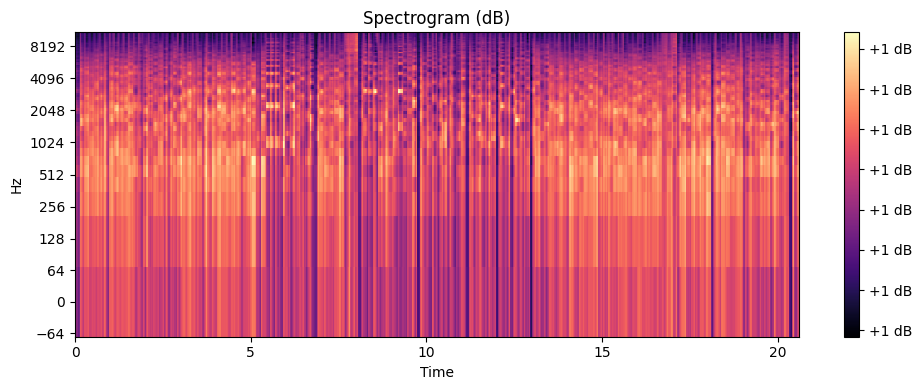

In [67]:
# 3. Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_linear, sr=sr, hop_length=512,
                         x_axis="time", y_axis="log")  # 'log' = log-frequency
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.tight_layout()
plt.show()

In [68]:
from IPython.display import Audio
Audio(y, rate=sr)